## **Cooper University Health Care, Enterprise Analytics Analyst position Case Study**

### By Venkata Mani Babu Karri
#### Master of Science in Applied Data Science
#### Indiana University Indianapolis
#### venkatamanibabukarri@gmail.com
#### 812-581-5642


### **Answers**

Based on the given problem statement and data description. I see this problem as a **Multi Label Text Classification** problem.

### **Desired Deliverables**

**Question 1:**
Using the existing labeled data, please create a classification model that can accurately categorize comments into the correct class. It can be seen that some comments belong to more than one category; therefore, perform appropriate modeling that can handle this case. What is your process?


**Answer:**

Since this a traditional Multi-Label text classification problem. We can use below approaches for building our classification models.


1.   Problem Transformation.
 *  Binary Relevance
 *  Classifier Chain
 *  Label Powerset
2.  Ensemble Models
3. Adapted Algorithms

The entire code building models using these approaches is mentioned below.

In [79]:
# Importing necessary libraries and models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from textblob import Word
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, jaccard_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Loading data
dict_df = pd.read_excel('/content/HCAHPS_Sample Generated Data.xlsx', sheet_name=['Labeled','Unlabeled'])
labeled_df = dict_df.get('Labeled')

In [6]:
labeled_df.head()

,Service,Unique ID,Comment,Hospital Staff,Hospital Environment,Discharge Process
0,Inpatient,1932322029,I was admitted to hospital for my elective kne...,1,0,0
1,Inpatient,1957027322,No one staff volunteer to take me out/or w/c a...,0,1,1
2,Inpatient,1983301098,Food was horrible. I wasn't given much guidan...,0,1,1
3,Inpatient,1995931675,Overall my experience was good. My doctors an...,1,1,0
4,Inpatient,2163080794,All the staff was great. I hated to leave. T...,1,0,0


**Data Exploration**

In [7]:
labeled_df.count()

Service                 70
Unique ID               70
Comment                 70
Hospital Staff          70
Hospital Environment    70
Discharge Process       70
dtype: int64

In [8]:
# Extract the labels columns (Hospital Staff, Hospital Environment, and Discharge Process)
labels = labeled_df[['Hospital Staff', 'Hospital Environment', 'Discharge Process']]

# Calculate the sum of labels for each category
label_sums = labels.sum()

# Calculate the sum of labels for each row (comment)
row_sums = labels.sum(axis=1)

# Count the number of rows with no labels
no_label_count = (row_sums == 0).sum()
one_label_count = (row_sums == 1).sum()
two_label_count = (row_sums == 2).sum()
three_label_count = (row_sums == 3).sum()

print("Total number of comments = ", len(labeled_df))
print("Total number of comments without any labels = ", no_label_count)
print("Total labels in 'Hospital Staff' = ", label_sums['Hospital Staff'])
print("Total labels in 'Hospital Environment' = ", label_sums['Hospital Environment'])
print("Total labels in 'Discharge Process' = ", label_sums['Discharge Process'])

Total number of comments =  70
Total number of comments without any labels =  0
Total labels in 'Hospital Staff' =  44
Total labels in 'Hospital Environment' =  30
Total labels in 'Discharge Process' =  19


In [9]:
print("Total number of comments without any labels = ", no_label_count)
print("Total number of comments with one label = ", one_label_count)
print("Total number of comments with two labels = ", two_label_count)
print("Total number of comments with three labels = ", three_label_count)

Total number of comments without any labels =  0
Total number of comments with one label =  47
Total number of comments with two labels =  23
Total number of comments with three labels =  0


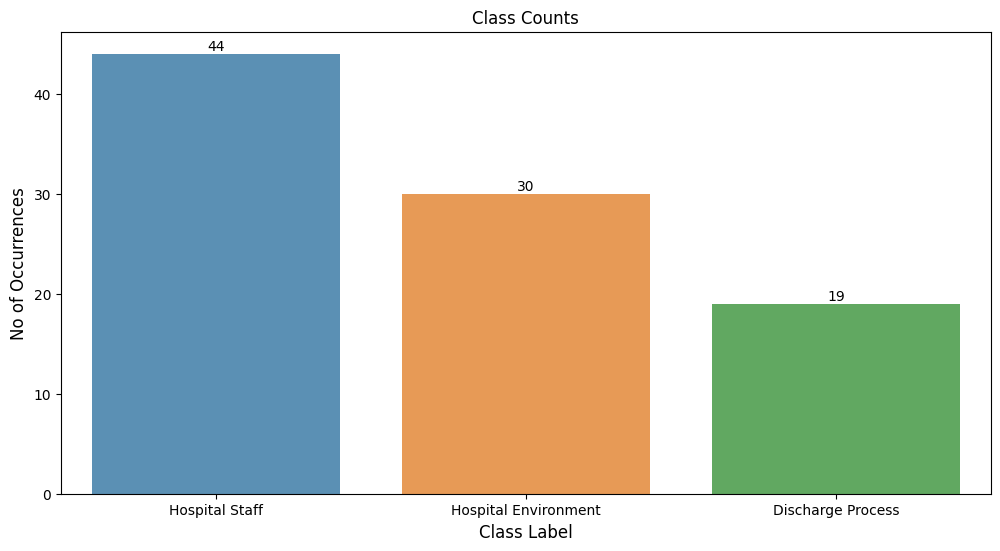

In [10]:
# Create a bar plot to visualize class counts
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=label_sums.index, y=label_sums.values, alpha=0.8)
plt.title("Class Counts")
plt.ylabel('No of Occurrences', fontsize=12)
plt.xlabel('Class Label', fontsize=12)

# Add labels to the bars
rects = ax.patches
for rect, label in zip(rects, label_sums.values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label, ha='center', va='bottom')

plt.show()

**Data Preprocessing**

In [11]:
labeled_df.dtypes

Service                 object
Unique ID                int64
Comment                 object
Hospital Staff           int64
Hospital Environment     int64
Discharge Process        int64
dtype: object

In [12]:
# Converting label data types to float
labeled_df['Hospital Staff'] = labeled_df['Hospital Staff'].astype(float)
labeled_df['Hospital Environment'] = labeled_df['Hospital Environment'].astype(float)
labeled_df['Discharge Process'] = labeled_df['Discharge Process'].astype(float)

In [13]:
labeled_df.dtypes

Service                  object
Unique ID                 int64
Comment                  object
Hospital Staff          float64
Hospital Environment    float64
Discharge Process       float64
dtype: object

In [14]:
labeled_df.head()

,Service,Unique ID,Comment,Hospital Staff,Hospital Environment,Discharge Process
0,Inpatient,1932322029,I was admitted to hospital for my elective kne...,1.0,0.0,0.0
1,Inpatient,1957027322,No one staff volunteer to take me out/or w/c a...,0.0,1.0,1.0
2,Inpatient,1983301098,Food was horrible. I wasn't given much guidan...,0.0,1.0,1.0
3,Inpatient,1995931675,Overall my experience was good. My doctors an...,1.0,1.0,0.0
4,Inpatient,2163080794,All the staff was great. I hated to leave. T...,1.0,0.0,0.0


In [15]:
# Dropping Service, Unique ID columns
labeled_df = labeled_df.drop(['Service','Unique ID'], axis = 1)

In [16]:
labeled_df.head()

,Comment,Hospital Staff,Hospital Environment,Discharge Process
0,I was admitted to hospital for my elective kne...,1.0,0.0,0.0
1,No one staff volunteer to take me out/or w/c a...,0.0,1.0,1.0
2,Food was horrible. I wasn't given much guidan...,0.0,1.0,1.0
3,Overall my experience was good. My doctors an...,1.0,1.0,0.0
4,All the staff was great. I hated to leave. T...,1.0,0.0,0.0


In [17]:
# Comment text preprocessing
labeled_df['Comment'] = labeled_df['Comment'].apply(lambda x: x.lower().strip().replace('\n', ' ').replace('\r', ' '))

labeled_df['Comment'] = labeled_df['Comment'].apply(lambda x: re.sub(r'http\S+', '', x))

tokenizer = RegexpTokenizer(r'\w+')

labeled_df['Comment'] = labeled_df.apply(lambda row: tokenizer.tokenize(row['Comment']), axis=1)

stop = [word for word in stopwords.words('english')]

labeled_df['Comment'] = labeled_df['Comment'].apply(lambda x: [item for item in x if item not in stop])

labeled_df['Comment'] = labeled_df['Comment'].astype('str')

labeled_df['Comment'] = labeled_df['Comment'].str.findall('\w{2,}')

labeled_df['Comment']= labeled_df['Comment'].str.join(' ')

lemmatizer = WordNetLemmatizer()

labeled_df['Comment'] = labeled_df['Comment'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [18]:
labeled_df['Comment'][2]

'food horrible given much guidance upon leaving diet restriction physical therapy given contradicting guidance activity level heart strong enough discharged'

**Feature Engineering**

In [19]:
x = labeled_df['Comment']

In [20]:
# Applying TF-IDF vectorizer on the comment text data
tfidf = TfidfVectorizer()
xfeatures = tfidf.fit_transform(x).toarray()

**Train, Test Split**

In [21]:
y = labeled_df[['Hospital Staff', 'Hospital Environment', 'Discharge Process']]

In [22]:
y.head()

,Hospital Staff,Hospital Environment,Discharge Process
0,1.0,0.0,0.0
1,0.0,1.0,1.0
2,0.0,1.0,1.0
3,1.0,1.0,0.0
4,1.0,0.0,0.0


In [23]:
x_train, x_test, y_train, y_test = train_test_split(xfeatures, y, test_size = 0.3, random_state = 42)

**Model Function**

First, I am trying different problem transformation techniques with different classifier models.

In [24]:
# Defining model function to try different comnination of techniques and models
def Classier_Model(technique,model,xtrain,ytrain,xtest,ytest):
  # Build and train model
  classifier = technique(model)
  classifier.fit(xtrain,ytrain)
  # Predictions
  classifier_predictions = classifier.predict(xtest)
  # Evaluation model performance
  acc = accuracy_score(ytest, classifier_predictions)
  hamm = hamming_loss(ytest, classifier_predictions)
  f1 = f1_score(ytest, classifier_predictions, average='micro')
  jacc = jaccard_score(ytest, classifier_predictions, average='macro')
  result = {"Accuracy Score":acc, "Hamming Loss":hamm, "F1 Score":f1, "Jaccard Score":jacc}
  return result

**Binary Relevance - Multinomial Naive Bayes Classifier**

In [25]:
br_mnb = Classier_Model(BinaryRelevance, MultinomialNB(),x_train,y_train,x_test,y_test)

In [26]:
br_mnb

{'Accuracy Score': 0.5714285714285714,
 'Hamming Loss': 0.20634920634920634,
 'F1 Score': 0.7547169811320756,
 'Jaccard Score': 0.4761904761904762}

**Binary Relevance - Logistic Regression Classifier**

In [27]:
br_lr = Classier_Model(BinaryRelevance,LogisticRegression(),x_train,y_train,x_test,y_test)

In [28]:
br_lr

{'Accuracy Score': 0.42857142857142855,
 'Hamming Loss': 0.2698412698412698,
 'F1 Score': 0.7017543859649122,
 'Jaccard Score': 0.3896103896103896}

**Binary Relevance - Support Vector Classifier**

In [29]:
br_svc = Classier_Model(BinaryRelevance,LinearSVC(),x_train,y_train,x_test,y_test)

In [30]:
br_svc

{'Accuracy Score': 0.6190476190476191,
 'Hamming Loss': 0.15873015873015872,
 'F1 Score': 0.8214285714285714,
 'Jaccard Score': 0.6444444444444445}

**Classifier Chain - Multinomial Naive Bayes**

In [31]:
cc_mnb = Classier_Model(ClassifierChain,MultinomialNB(),x_train,y_train,x_test,y_test)

In [32]:
cc_mnb

{'Accuracy Score': 0.5238095238095238,
 'Hamming Loss': 0.23809523809523808,
 'F1 Score': 0.6808510638297872,
 'Jaccard Score': 0.3047619047619048}

**Classifier Chain - Logistic Regresstion Classifier**

In [33]:
cc_lr = Classier_Model(ClassifierChain,LogisticRegression(),x_train,y_train,x_test,y_test)

In [34]:
cc_lr

{'Accuracy Score': 0.5238095238095238,
 'Hamming Loss': 0.25396825396825395,
 'F1 Score': 0.6521739130434783,
 'Jaccard Score': 0.2380952380952381}

**Classifier Chain - Support Vector Classifier**

In [35]:
cc_svc = Classier_Model(ClassifierChain,LinearSVC(),x_train,y_train,x_test,y_test)

In [36]:
cc_svc

{'Accuracy Score': 0.6190476190476191,
 'Hamming Loss': 0.19047619047619047,
 'F1 Score': 0.7499999999999999,
 'Jaccard Score': 0.4587301587301587}

**Label Powerset - Multinomial Naive Bayes**

In [37]:
lp_mnb = Classier_Model(LabelPowerset,MultinomialNB(),x_train,y_train,x_test,y_test)

In [38]:
lp_mnb

{'Accuracy Score': 0.6190476190476191,
 'Hamming Loss': 0.23809523809523808,
 'F1 Score': 0.6938775510204083,
 'Jaccard Score': 0.40740740740740744}

**Label Powerset - Logistic Regression Classifier**

In [39]:
lp_lr = Classier_Model(LabelPowerset,LogisticRegression(),x_train,y_train,x_test,y_test)

In [40]:
lp_lr

{'Accuracy Score': 0.6190476190476191,
 'Hamming Loss': 0.2222222222222222,
 'F1 Score': 0.7083333333333334,
 'Jaccard Score': 0.420479302832244}

**Label Powerset - Support Vector Classifier**

In [41]:
lp_svc = Classier_Model(LabelPowerset,LinearSVC(),x_train,y_train,x_test,y_test)

In [42]:
lp_svc

{'Accuracy Score': 0.7142857142857143,
 'Hamming Loss': 0.15873015873015872,
 'F1 Score': 0.7916666666666667,
 'Jaccard Score': 0.5916666666666667}

**Ensemble Models**

**Ensemble Model - Random Forest Classifier**

In [65]:
em_rf = Classier_Model(MultiOutputClassifier,RandomForestClassifier(n_estimators=150),x_train,y_train,x_test,y_test)

In [66]:
em_rf

{'Accuracy Score': 0.47619047619047616,
 'Hamming Loss': 0.20634920634920634,
 'F1 Score': 0.7636363636363636,
 'Jaccard Score': 0.49595959595959593}

**Ensemble Model - AdaBoost Classifier**

In [75]:
em_abc = Classier_Model(MultiOutputClassifier,AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=100),x_train,y_train,x_test,y_test)

In [76]:
em_abc

{'Accuracy Score': 0.6190476190476191,
 'Hamming Loss': 0.19047619047619047,
 'F1 Score': 0.76,
 'Jaccard Score': 0.6184640522875817}

**Ensemble Model - XGBoost Classifier**

In [77]:
em_xgb = Classier_Model(MultiOutputClassifier,xgb.XGBClassifier(n_estimators=100),x_train,y_train,x_test,y_test)

In [78]:
em_xgb

{'Accuracy Score': 0.5238095238095238,
 'Hamming Loss': 0.20634920634920634,
 'F1 Score': 0.7636363636363636,
 'Jaccard Score': 0.5730837789661319}

**Ensemble Model - Voting Ensemble**

In [52]:
# Create multiple base classifiers
base_classifiers = [
    ('logistic', LogisticRegression()),
    ('naive_bayes', MultinomialNB()),
    ('random_forest', RandomForestClassifier(n_estimators=100))
]

# Create a multi-output classifier using Voting
ve_multi_label_classifier = MultiOutputClassifier(VotingClassifier(estimators=base_classifiers, voting='soft'))

# Fit the classifier to your data
ve_multi_label_classifier.fit(x_train, y_train)

# Make predictions
ve_predictions = ve_multi_label_classifier.predict(x_test)

In [80]:
print(f'Accuracy Score: {accuracy_score(y_test,ve_predictions)}')
print(f'Hamming Loss: {hamming_loss(y_test,ve_predictions)}')
print(f'F1 Score: {f1_score(y_test,ve_predictions, average="micro")}')
print(f'Jaccard Score: {jaccard_score(y_test,ve_predictions, average="macro")}')

Accuracy Score: 0.47619047619047616
Hamming Loss: 0.25396825396825395
F1 Score: 0.7142857142857142
Jaccard Score: 0.4047619047619048


Among all the models I trained and tested, **LinearSVC with Label Powerset** problem transormation technique gave me the best performance. I can use cross-validation technique to find whether the model is overfitting or underfitting and also maximum possible data for training. And also for finding the best set of hyper parameters. Due to time contraint, I am using the best performing model among the above models for my further analysis. Since the data is very limited complex models like Neural Networks, BERT, LSTM and LLMs will prone to overfitting and will be unable to generalize.

**Question 2:**
Categorize the unlabeled data into correct classes using the model in previous step. What is the performance of this process? Use appropriate accuracy measures.


**Answer:**

To categorize the unlabeled data into correct classes I am using LinearSVC with Label Powerset problem transformation technique which is the best performing model. Since I am using a model with an accuracy of 71.42% the performance of this process would be around the same. I can additionally use the second best performing model for validation the accuracy.

In [81]:
# Loading unlabeled data into a dataframe
unlabeled_df = dict_df.get('Unlabeled')

In [82]:
unlabeled_df.head()

,Service,Unique ID,Comment
0,Inpatient,2169749624,Wanted to send me home with the equipment I ne...
1,Inpatient,2199125796,This was my first hospital stay so I have no c...
2,Inpatient,2199126287,PACU nurse treated me with the utmost respect ...
3,Inpatient,2199125996,The pain from 2 pins placed in L hip were pain...
4,Inpatient,2186037422,The last night nurse took it on her own not to...


In [83]:
# Text preprocessing
unlabeled_df['Comment'] = unlabeled_df['Comment'].apply(lambda x: x.lower().strip().replace('\n', ' ').replace('\r', ' '))

unlabeled_df['Comment'] = unlabeled_df['Comment'].apply(lambda x: re.sub(r'http\S+', '', x))

tokenizer = RegexpTokenizer(r'\w+')

unlabeled_df['Comment'] = unlabeled_df.apply(lambda row: tokenizer.tokenize(row['Comment']), axis=1)

stop = [word for word in stopwords.words('english')]

unlabeled_df['Comment'] = unlabeled_df['Comment'].apply(lambda x: [item for item in x if item not in stop])

unlabeled_df['Comment'] = unlabeled_df['Comment'].astype('str')

unlabeled_df['Comment'] = unlabeled_df['Comment'].str.findall('\w{2,}')

unlabeled_df['Comment']= unlabeled_df['Comment'].str.join(' ')

lemmatizer = WordNetLemmatizer()

unlabeled_df['Comment'] = unlabeled_df['Comment'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [84]:
unlabeled_df['Comment'][2]

'pacu nurse treated utmost respect entire time care care give patient absolutely exceptional'

In [85]:
x_unlabeled = unlabeled_df['Comment']

In [96]:
# Applying TF-IDF vectorizer on the comment text data
# Feature Engineering
tfidf = TfidfVectorizer()
x_unlabeled_features = tfidf.fit_transform(x_unlabeled).toarray()

In [97]:
lp_lsvc = LabelPowerset(LinearSVC())
lp_lsvc.fit(x_train,y_train)

LabelPowerset(classifier=LinearSVC(), require_dense=[True, True])

In [98]:
unlabeled_comment_labels = lp_lsvc.predict(x_test)

In [102]:
x_train.shape

(49, 517)

In [99]:
x_test.shape

(21, 517)

In [103]:
x_unlabeled.shape

(30,)

In [101]:
x_test

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.1862275, 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [104]:
unlabeled_df.dtypes

Service      object
Unique ID     int64
Comment      object
dtype: object